# Построение движка для игр на pygame - урок 7

## Повторение

У нас в классе накопилось большое число методов, давайте разобъем эти методы по отдельным классам, что бы как то разгрузить родительский класс и сделать его более универсальным. Это позволит нам масштабировать код, быстро ориентироваться в коде и интуитивно понимать возможности классов.

In [ ]:
import pygame


class Object:
    def __init__(self, parent: pygame.Surface, width=40, height=40, x=0, y=0, color=(255, 255, 255)):
        self.parent = parent
        self.x, self.y = x, y
        self.color = color

        self.skin = pygame.Surface(size=(width, height))
        self.skin.fill(color=color)
        self.body = self.skin.get_rect(topleft=(x, y))

    def blit(self):
        return self.parent.blit(source=self.skin, dest=self.body)

    def recolor(self, color):
        self.skin.fill(color=color)
        return color

    def replace(self, x=None, y=None):
        if x:
            self.x = x
        if y:
            self.y = y
        self.body.x = self.x
        self.body.y = self.y


class Character(Object):
    def __init__(self, parent: pygame.Surface, width=40, height=40, x=0, y=0, color=(255, 255, 255), speed=1):
        super().__init__(parent, width, height, x, y, color)
        self.speed = speed

    def __diagonal_speed(self):
        speed_xy = (self.speed ** 2 + self.speed ** 2) ** (1 / 2)  # находим длину вектора x + y по пифагору
        speed_xy = self.speed / speed_xy  # находим долю скорости от суммы векторов
        speed_xy *= self.speed  # теперь находим скорость по диагонали
        return speed_xy

    def motion_control(self):
        left = pygame.key.get_pressed()[97]
        right = pygame.key.get_pressed()[100]
        up = pygame.key.get_pressed()[119]
        down = pygame.key.get_pressed()[115]

        speed = self.__diagonal_speed() if (left + right + up + down) > 1 else self.speed

        self.x -= left * speed
        self.x += right * (speed + 1) if speed % 1 != 0 else right * speed
        self.y -= up * speed
        self.y += down * (speed + 1) if speed % 1 != 0 else down * speed

        self.replace()
        return -left * speed, right * speed, -up * speed, down * speed

    def change_speed(self, speed):
        self.speed = speed
        return speed


class Barrier(Object):
    def __init__(self, parent: pygame.Surface, objects: list, width=40, height=40, x=0, y=0, color=(255, 255, 255)):
        super().__init__(parent, width, height, x, y, color)
        self.objects = objects

    def resistance(self):
        for obj in self.objects:
            collision = self.body.colliderect(obj.body)
            if collision:
                resist_sides = {
                    'left': abs(self.body.left - obj.body.right),
                    'right': abs(self.body.right - obj.body.left),
                    'top': abs(self.body.top - obj.body.bottom),
                    'bottom': abs(self.body.bottom - obj.body.top)
                }
                min_dip = [key for key, val in resist_sides.items() if val == min(resist_sides.values())]

                if 'left' in min_dip:
                    obj.body.right = self.body.left
                elif 'right' in min_dip:
                    obj.body.left = self.body.right
                elif 'top' in min_dip:
                    obj.body.bottom = self.body.top
                elif 'bottom' in min_dip:
                    obj.body.top = self.body.bottom

                return collision
        return 0

## Загрузка спрайтов

Сначало просмотрим, что из себя представляет само окно, скин персонажей и все что мы можем увидеть глазами. Для этого залезем в документацию метода для создания окон.

In [ ]:
pygame.display.set_mode

In [ ]:
def set_mode(
    size: Optional[Union[Tuple[int, int], Sequence[int]]],
    flags: Optional[int] = 0,
    depth: Optional[int] = 0,
    display: Optional[int] = 0,
    vsync: Optional[int] = 0
) -> Surface: ...

Здесь мы можем видеть все аргументы данного метода, у каждого аргумента есть небольшое описание, например мы можем видеть, что здесь все аргументы принимают целое число.

Так же можно видеть, что все аргументы, кроме первого, имеют значения по умолчанию. Что за что отвечают эти аргументы, можно узнать из интернета, или эмпирическим путем.

Так же, в конце метода, мы можем видеть стрелку -> Surface - это то, что нас сейчас интересует. Это класс - покрытие - это и есть, что мы видем. Мы его уже использовали, что бы создать скин для внутреигровых объектов.

In [ ]:
pygame.Surface(size=(width, height))

Этот класс имеет соответствующие методы, если мы увидем его еще в каких нибудь методах, то будем знать, как его можно использовать.

Теперь рассмотрим метод для загрузки картинок.

Скачайте [спрайты](https://github.com/Yegor9151/for_corund/blob/main/python/module%203/viking.rar?raw=true)

In [ ]:
from first_engine.game import Game
from first_engine import objects
import pygame


class FirstGame(Game):
    def run(self):
        hero = objects.Character(self.surface, speed=8)
        stand = pygame.image.load('./sprites/viking/stand/right/1.png') # загружаем картинку

        game_over = False
        while self.RUNNER:
            if not game_over:
                self.cycle_init(objects=[hero], FPS=60)

                self.surface.blit(stand, hero.body) # отображаем картинку на род окне, по координатам тела персонажа
                hero.motion_control()

            for event in self.events():
                # print(event)  # отслеживание событий
                self.close(event)


FirstGame(width=600, height=400).run()

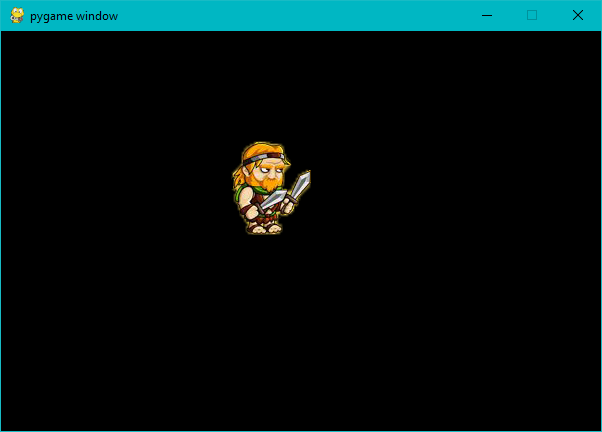

После загрузки, картинка точно таким же методом отображается на родительском окне, как мы делали в методе __blit__ класса __Character__.<br>
Давайте заглянем в документацию __pygame.image.load__

def load(filename: Union[AnyPath, IO], namehint: Optional[str] = "") -> Surface: ...

Можем увидеть здесь, что этот метод возвращает __Surface__, это точно такий же объект, при помощи которого мы создавали метод в виде квадрата в методе конструкторе класса __Object__.

Но здесь есть проблема, скин персонажа имеет один размер, а его тела гругой размер. Давайте вспомним, что тело героя делается на основе __Surface__, вот и здесь нам нужно сделать так же.

In [ ]:
from first_engine.game import Game
from first_engine import objects
import pygame


class FirstGame(Game):
    def run(self):
        hero = objects.Character(self.surface, speed=8)
        stand_right = pygame.image.load('./sprites/viking/stand/right/1.png')
        hero.body = stand_right.get_rect() # создаем тело на основе скина

        game_over = False
        while self.RUNNER:
            if not game_over:
                self.cycle_init(objects=[hero], FPS=60)

                self.surface.blit(stand_right, hero.body)
                hero.motion_control()

            for event in self.events():
                # print(event)  # отслеживание событий
                self.close(event)


FirstGame(width=600, height=400).run()

Вот теперь все работает корректно, но что если скины имеют разные размеры? тогда получается, что нам нужно не только вначале, а постоянно пересоздавать тела на основе назных __Surface__, для этого давайте дополним метод __blit__ в классе __Object__.

In [ ]:
class Object:
    def __init__(self, parent: pygame.Surface, width=40, height=40, x=0, y=0, color=(255, 255, 255)):...

    def blit(self):
        self.body = self.skin.get_rect(topleft=(self.x, self.y)) # создаем тело по новым координатам
        return self.parent.blit(source=self.skin, dest=self.body)

    def recolor(self, color):...

    def replace(self, x=None, y=None):...

Давайте сделаем новый метод __load_sprites__ для класса __Object__. Он будет отвечать за загрузку спрайтов. В дальнейшем мы так же будем его по тихоньку улучшать. Начнем с просого:

In [ ]:
class Object:
    def __init__(self, parent: pygame.Surface, width=40, height=40, x=0, y=0, color=(255, 255, 255)):
        self.parent = parent
        self.x, self.y = x, y
        self.color = color

        self.skin = pygame.Surface(size=(width, height))
        self.skin.fill(color=color)
        self.body = self.skin.get_rect(topleft=(x, y))

    def load_sprites(self, path: str):
        self.skin = pygame.image.load(path) # загружаем спрайт
        self.body = self.skin.get_rect(topleft=(self.x, self.y)) # создаем тело на его основе
        return self.body

    def blit(self):...

    def recolor(self, color):...

    def replace(self, x=None, y=None):...

Давайте попробуем добавить какую нибудь анимацию

In [ ]:
from first_engine.game import Game
from first_engine import objects
import pygame


class FirstGame(Game):
    def run(self):
        hero = objects.Character(self.surface, speed=8)
        stand_right = pygame.image.load('./sprites/viking/stand/right/1.png')
        run_right = pygame.image.load('./sprites/viking/run/right/1.png')  # добавляем картинку с бегом

        game_over = False
        while self.RUNNER:
            if not game_over:
                self.cycle_init(objects=[hero], FPS=60)

                sides = hero.motion_control()  # сохраняем возвращаемые значения
                
                hero.blit()  # для отладки
                if sum(sides) == 0: # если движений нет
                    self.surface.blit(stand_right, hero.body)
                else: # если движение есть
                    self.surface.blit(run_right, hero.body)

            for event in self.events():
                # print(event)
                self.close(event)


FirstGame(width=600, height=400).run()

Теперь мы можем видеть, что картинки меняются в зависисмости от того нажаты ли клавищи движения

Давайте немного допишем возврат метода __motion_control__, что бы нам было удобнее ориентироваться

In [ ]:
class Character(Object):
    def __init__(self, parent: pygame.Surface, width=40, height=40, x=0, y=0, color=(255, 255, 255), speed=1):...

    def __diagonal_speed(self):...

    def motion_control(self):
        left = pygame.key.get_pressed()[97]
        right = pygame.key.get_pressed()[100]
        up = pygame.key.get_pressed()[119]
        down = pygame.key.get_pressed()[115]

        speed = self.__diagonal_speed() if (left + right + up + down) > 1 else self.speed

        self.x -= left * speed
        self.x += right * (speed + 1) if speed % 1 != 0 else right * speed
        self.y -= up * speed
        self.y += down * (speed + 1) if speed % 1 != 0 else down * speed

        self.replace()
        # сделаем возврат ввиде Dict
        return {'left': -left * speed, 'right': right * speed, 'up': -up * speed, 'down': down * speed}

    def change_speed(self, speed):...

Теперь будет немного легче ориентироваться в ток, какая кнопка была нажата

## Задание:

- Сделайте, так, что бы персонаж разворачивался в ту сторону, в которую была нажата кнопка движения
- Добавьте анимацию атаки в ту сторону, куда смотрит перс

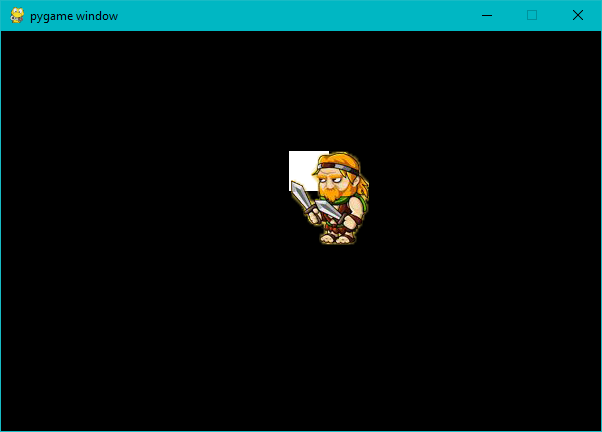